In this file we form a graph using the grid extracted in the previous notebook.

First we import all of the stuff needed and make a couple of definitions.

In [8]:
from awpy.visualization.plot import plot_map
from matplotlib import pyplot as plt
from awpy.data import NAV
import numpy as np
import pickle

unit = 105

def dist(x1,y1,x2,y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**.5

Let's load the grid created before (and sort it by the value of the points, thus from the bottom left corner onward).

In [9]:
points_list = list()
points_area = list()

with open('cleaned_extraction.pickle', 'rb') as handle:
    points_list, points_area = pickle.load(handle)

sort_ver = sorted(zip(points_list, points_area))
points_list = [list(item[0]) for item in sort_ver]
points_area = [item[1] for item in sort_ver]

# Yea yea, further manual corrections
points_list[418][2] = points_list[417][2]
points_list[193][2] = points_list[192][2]
points_list[126][2] = points_list[125][2]
points_list[810][2] = points_list[809][2]
points_list[837][2] = points_list[791][2]
points_list[838][2] = points_list[791][2]
points_list[839][2] = points_list[791][2]

Done with the loading we now proceed with the creation of the connections: the workings are defined in the docs, again.
Essentially what we are now creating is a directed graph, if the neighbor of a point lies at a height non-greater than 70 from his own and if there doesn't exist another neighbor on the same place but with a nearer height.

In [10]:
connections = list()

for i, (p, parea) in enumerate(zip(points_list, points_area)):
    possible_arcs = list()
    for j, (q, qarea) in enumerate(zip(points_list, points_area)):
        if i != j and unit * 0.8 <= dist(p[0], p[1], q[0], q[1]) <= unit * 1.2 and q[2] - p[2] <= 70:
            if parea != "ExtendedA" and parea != "Short" or qarea != "CTSpawn":
                aaa = None
                for t in possible_arcs:
                    if points_list[t][0] == q[0] and points_list[t][1] == q[1]:
                        aaa = t
                        break
                if aaa != None:
                    if points_list[aaa][2] < q[2]:
                        possible_arcs.remove(aaa)
                        possible_arcs.append(j)
                else:
                    possible_arcs.append(j)

    connections.append(possible_arcs)

n_of_edges = [len(set_of_edges) for set_of_edges in connections]

print(max(n_of_edges), min(n_of_edges))
print(sum([len(set_of_edges) for set_of_edges in connections]) / len(connections))

6 1
4.940020682523268


As we can see here the number of edges is at least one for each point (if it weren't so we'd be in big trouble, how can we model somebody moving if it stands on a hex without connections?). And furthermore the average amount of connections is around 5.

Let's now give a look at our work.

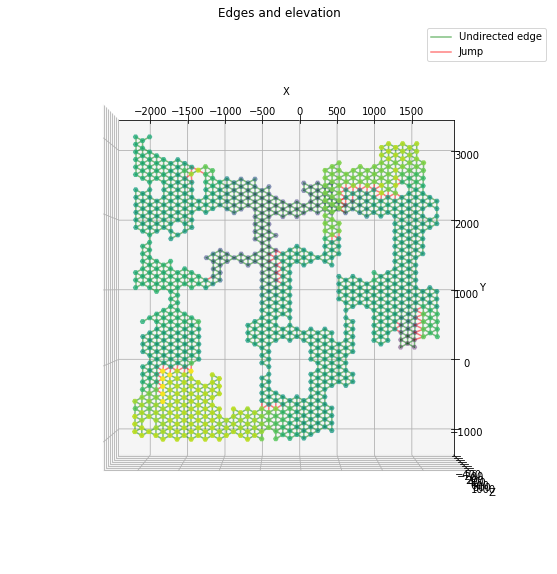

In [11]:
azim = -90
elev = 90

np_points = np.array(points_list).T

areas = list(frozenset(points_area))

point_area_indexes = [areas.index(area) for area in points_area]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(np_points[0], np_points[1], np_points[2], c=np_points[2], cmap="viridis", marker="H")


for i, arcs in enumerate(connections):
    x,y,z = points_list[i]
    for arc in arcs:
        if i in connections[arc]:
            if arc > i:
                ax.plot([x, points_list[arc][0]],[y, points_list[arc][1]],[z, points_list[arc][2]], color="green", alpha=0.5, label="Undirected edge")
        else:
            ax.plot([x, points_list[arc][0]],[y, points_list[arc][1]],[z, points_list[arc][2]], color="red", alpha=0.5, label="Jump")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(-500, 1000)

ax.azim = azim
ax.elev = elev
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Edges and elevation")

plt.show()

Looks nice! Let's store it.

(The connect_from is something we'll need later)

In [13]:
connect_from = [list() for _ in range(len(points_list))]

for i in range(len(points_list)):
    for j in range(len(points_list)):
        if i != j and j in connections[i]:
            connect_from[j].append(i)

to_store = (points_list, points_area, connections, connect_from)

with open('graph_AAA.pickle', 'wb') as handle:
    pickle.dump(to_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Visibility matrix (useless)

As we've talked in our document (and we'll talk during the presentation) this part turned out a fiasco, it is essentially an interactive system which lets the user define, for each point, what other points are visible on the map, if a player stood there.

Unfortunately though, as we've written, the system (and believe us, all systems) that we used, `awpy`, doesm't expose a nice way to show the fact that a player sees another during an instant in the match, thus this thing is essentially useless.

Anyway we leave it here... after all I (Davide) worked on it for countless hours and multiple iterations in April...

In [8]:
# Interactive obstacle maker
import cv2

visibility_matrix = [[True if i == j else False for j in range(len(points_list))] for i in range(len(points_list))]

with open('visibility_matrix.pickle', 'rb') as handle:
    visibility_matrix = pickle.load(handle)


img = cv2.imread("de_dust2_prepped.png")

ct_show = True

m = 0
n = 0
a = 1
b = 1

displace = (0,0)
pivot = (0,0)

for y, row in enumerate(img):
    for x, color in enumerate(row):
        if color[0] == 255 and color[1] == 0 and color[2] == 0:
            displace = (x+1,y)
        elif color[0] == 0 and color[1] == 0 and color[2] == 255:
            pivot = (x+1,y)

m, n = pivot
a = (displace[0] - m) / 47
b = (displace[1] - n) / 47

def make_visible(i,j):
    global visibility_matrix
    visibility_matrix[i][j] = True
    visibility_matrix[j][i] = True

def remove_visible(i,j):
    global visibility_matrix
    if i != j:
        visibility_matrix[i][j] = False
        visibility_matrix[j][i] = False

def distance_2d(x,y,i):
    return ((x - points_list[i][0]) ** 2 + (y - points_list[i][1]) ** 2) ** .5

def return_closer(x,y):
    min_d = np.inf
    j = -1

    for i in range(len(points_list)):
        area = points_area[i]
        if ct_show:
            if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                continue
        else:
            if area == "CTSpawn":
                continue
        d = distance_2d(x,y,i)
        if min_d > d:
            min_d = d
            j = i

    return j, min_d


currently_selected = -1
mode = -1

selected = set()

area_select_base = (0,0)
area_select_part = 0

curr_x = 0
curr_y = 0

def mousePoints(event,x,y,flags,params):
    global mode
    global currently_selected
    global ct_show
    global area_select_base
    global area_select_part
    global curr_x
    global curr_y
    global visibility_matrix
    global selected

    curr_x = x
    curr_y = y


    if event == cv2.EVENT_RBUTTONDOWN:
        area_select_part = 0
        area_select_base = (0,0)
        selected.clear()
        return
    elif event != cv2.EVENT_LBUTTONDOWN:
        return

    elif mode == -3 and currently_selected > -1:
        i, distance = return_closer((x - m) / a, (y - n) / b)
        if distance < 105 * 0.5:
            for j in range(len(points_list)):
                if visibility_matrix[j][i]:
                    make_visible(currently_selected, j)
    if mode == -1:
        i, distance = return_closer((x - m) / a, (y - n) / b)
        if distance < 105:
            currently_selected = i
        else:
            currently_selected = -1
    elif mode == 4 and len(selected) == 0:
        if area_select_part == 0:
            area_select_base = (x,y)
            area_select_part = 1
        else:
            x0 = (x - m) / a
            y0 = (y - n) / b

            area_select_base = ((area_select_base[0] - m) / a, (area_select_base[1] - n) / b)

            min_x = min(x0, area_select_base[0])
            max_x = max(x0, area_select_base[0])
            min_y = min(y0, area_select_base[1])
            max_y = max(y0, area_select_base[1])

            for i, point in enumerate(points_list):
                area = points_area[i]
                if ct_show:
                    if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                        continue
                else:
                    if area == "CTSpawn":
                        continue
                if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                    selected.add(i)

            area_select_part = 0
    elif mode == 4 and len(selected) != 0:
        if area_select_part == 0:
            area_select_base = (x,y)
            area_select_part = 1
        else:
            x0 = (x - m) / a
            y0 = (y - n) / b

            area_select_base = ((area_select_base[0] - m) / a, (area_select_base[1] - n) / b)

            min_x = min(x0, area_select_base[0])
            max_x = max(x0, area_select_base[0])
            min_y = min(y0, area_select_base[1])
            max_y = max(y0, area_select_base[1])

            for i, point in enumerate(points_list):
                area = points_area[i]
                if ct_show:
                    if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                        continue
                else:
                    if area == "CTSpawn":
                        continue
                if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                    selected.add(i)

            for i in selected:
                for j in selected:
                    make_visible(i,j)
            area_select_part = 0
            selected.clear()
    elif mode == 0 and currently_selected > -1:
        i, distance = return_closer((x - m) / a, (y - n) / b)
        if distance < 105 * 0.5:
            make_visible(currently_selected, i)
    elif mode == 1 and currently_selected > -1:
        if area_select_part == 0:
            area_select_base = (x,y)
            area_select_part = 1
        else:
            x0 = (x - m) / a
            y0 = (y - n) / b

            area_select_base = ((area_select_base[0] - m) / a, (area_select_base[1] - n) / b)

            min_x = min(x0, area_select_base[0])
            max_x = max(x0, area_select_base[0])
            min_y = min(y0, area_select_base[1])
            max_y = max(y0, area_select_base[1])

            for i, point in enumerate(points_list):
                area = points_area[i]
                if ct_show:
                    if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                        continue
                else:
                    if area == "CTSpawn":
                        continue
                if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                    make_visible(currently_selected, i)

            area_select_part = 0
    elif mode == 2 and currently_selected > -1:
        i, distance = return_closer((x - m) / a, (y - n) / b)
        if distance < 105 * 0.5:
            remove_visible(currently_selected, i)
    elif mode == 3 and currently_selected > -1:
        if area_select_part == 0:
            area_select_base = (x,y)
            area_select_part = 1
        else:
            x0 = (x - m) / a
            y0 = (y - n) / b

            area_select_base = ((area_select_base[0] - m) / a, (area_select_base[1] - n) / b)

            min_x = min(x0, area_select_base[0])
            max_x = max(x0, area_select_base[0])
            min_y = min(y0, area_select_base[1])
            max_y = max(y0, area_select_base[1])

            for i, point in enumerate(points_list):
                area = points_area[i]
                if ct_show:
                    if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                        continue
                else:
                    if area == "CTSpawn":
                        continue
                if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                    remove_visible(currently_selected, i)

            area_select_part = 0
    elif mode == -2:
        if area_select_part == 0:
            area_select_base = (x,y)
            area_select_part = 1
        else:
            x0 = (x - m) / a
            y0 = (y - n) / b

            area_select_base = ((area_select_base[0] - m) / a, (area_select_base[1] - n) / b)

            min_x = min(x0, area_select_base[0])
            max_x = max(x0, area_select_base[0])
            min_y = min(y0, area_select_base[1])
            max_y = max(y0, area_select_base[1])

            points_indexes = set()

            for i, point in enumerate(points_list):
                area = points_area[i]
                if ct_show:
                    if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                        continue
                else:
                    if area == "CTSpawn":
                        continue
                if min_x <= point[0] <= max_x and min_y <= point[1] <= max_y:
                    points_indexes.add(i)

            for i in points_indexes:
                for j in points_indexes:
                    make_visible(j, i)

            area_select_part = 0
    elif mode == 5 and currently_selected != -1:
        x0 = (x - m) / a
        y0 = (y - n) / b
        pt = points_list[currently_selected]
        x0 -= pt[0]
        y0 -= pt[1]
        if area_select_part == 0:
            area_select_base = (x0,y0)
            area_select_part = 1
        else:
            max_dist = (x0**2 + y0**2)**.5
            x1,y1 = area_select_base
            base_dist = (x1**2 + y1**2) **.5
            angle = np.arccos((x0*x1 + y0*y1) / (max_dist * base_dist))
            lr_choice = y0 >= y1/x1 * x0

            for i, point in enumerate(points_list):
                area = points_area[i]
                if ct_show:
                    if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                        continue
                else:
                    if area == "CTSpawn":
                        continue
                y2 = point[1] - pt[1]
                x2 = point[0] - pt[0]
                curr_dist = (x2**2 + y2**2)**.5
                if 0 < curr_dist <= max_dist:
                    curr_angle = np.arccos((x2*x1 + y2*y1) / curr_dist / base_dist)
                    if curr_angle <= angle and (y2 >= y1/x1 * x2) == lr_choice:
                        make_visible(currently_selected, i)

            area_select_part = 0


title = "Interactive obstacle query"

cv2.namedWindow(title)
cv2.setMouseCallback(title, mousePoints)

run = True

while run:
    buff_img = img.copy()

    x0, y0 = 0,0
    x1, y1 = 0,0
    x2, y2 = 0,0

    area_col = (0,0,0)
    use_area = False
    
    if (mode == 1 or mode == 3 or mode == -2 or mode == 4 or mode == 5) and area_select_part == 1:
        use_area = True
        if mode == 1 or mode == 5:
            area_col = (255,0,0)
        elif mode == 3:
            area_col = (0,0,255)
        elif mode == -2:
            area_col = (0, 255, 255)
        elif mode == 4:
            area_col = (0, 165, 255)

        if mode != 5:
            x1 = min(int(area_select_base[0]),int(curr_x))
            x2 = max(int(area_select_base[0]),int(curr_x))
            y1 = min(int(area_select_base[1]),int(curr_y))
            y2 = max(int(area_select_base[1]),int(curr_y))
            cv2.rectangle(buff_img, (x1,y1), (x2,y2), area_col, 1)
        else:
            pt = points_list[currently_selected]
            x1 = pt[0] * a + m
            y1 = pt[1] * b + n
            radii = ((curr_x - x1)**2 + (curr_y - y1)**2)**.5

            dist_too = (area_select_base[0]**2 + area_select_base[1]**2)**0.5
            x2 = int(area_select_base[0] * radii/dist_too + x1)
            y2 = int(-area_select_base[1] * radii/dist_too + y1)

            x1 = int(x1)
            y1 = int(y1)
            
            cv2.line(buff_img, (x1,y1), (curr_x,curr_y), area_col, 1)
            cv2.line(buff_img, (x1,y1), (x2,y2), area_col, 1)
            cv2.circle(buff_img, (x1,y1), int(radii), area_col, 1)

    for i,point in enumerate(points_list):
        area = points_area[i]
        if ct_show:
            if area == "Short" or area == "ExtendedA" or  area == "Catwalk":
                continue
        else:
            if area == "CTSpawn":
                continue

        x0 = int(point[0] * a + m)
        y0 = int(point[1] * b + n)
        col = (255,0,255)

        if use_area:
            if mode != 5 and x1 <= x0 <= x2 and y1 <= y0 <= y2:
                col = area_col
            elif mode == 5:
                pt = points_list[currently_selected]
                x1 = pt[0]
                y1 = pt[1]
                x2 = point[0] - x1
                y2 = point[1] - y1
                curr_dist = (x2**2 + y2**2)**.5
                curr_x_m = (curr_x - m) / a - x1
                curr_y_m = (curr_y - n) / b - y1
                radii = (curr_x_m**2 + curr_y_m**2)**.5
                if 0 < curr_dist <= radii:
                    dist_too = (area_select_base[0]**2 + area_select_base[1]**2)**0.5
                    x3 = area_select_base[0]
                    y3 = area_select_base[1]
                    curr_angle = np.arccos((x2*x3 + y2*y3) / curr_dist / dist_too)
                    angle = np.arccos((curr_x_m*x3 + curr_y_m*y3) / radii / dist_too)
                    if curr_angle <= angle and (y2 >= y3/x3 * x2) == (curr_y_m >= y3/x3 * curr_x_m):
                        col = area_col
                    
        if i in selected:
            col = (0, 165, 255)

        if currently_selected != -1:
            if i == currently_selected:
                col = (0, 255, 255)
            elif visibility_matrix[currently_selected][i]:
                col = (255,255,0)
        
        cv2.circle(buff_img, (x0, y0), int(105 * 0.4 * a), col, 1)

    cv2.putText(buff_img, f"select:{currently_selected}", (20,30), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
    cv2.imshow(title, buff_img)

    key = cv2.waitKey(10)

    if key == ord("q"):
        run = False
    elif key == 49:
        if currently_selected > 0:
            currently_selected -= 1
    elif key == 50:
        if currently_selected > -1 and currently_selected < len(points_list) - 1:
            currently_selected += 1
    elif key == ord("c"): # Copy Viz
        mode = -3
        area_select_part = 0
        area_select_base = (0,0)
    elif key == ord("w"): # Select for viz all
        mode = -2
        area_select_part = 0
        area_select_base = (0,0)
    elif key == ord("v"): # Select for viz
        mode = -1
        area_select_part = 0
        area_select_base = (0,0)
        currently_selected = -1
    elif key == ord("s"): # Select
        mode = 0
        area_select_part = 0
        area_select_base = (0,0)
    elif key == ord("a"): # Area select
        mode = 1
        area_select_part = 0
        area_select_base = (0,0)
    elif key == ord("d"): # Deselect
        mode = 2
        area_select_part = 0
        area_select_base = (0,0)
    elif key == ord("f"): # Area deselect
        mode = 3
        area_select_part = 0
        area_select_base = (0,0)
    elif key == ord("k"): # Area viz-to-viz
        mode = 4
        area_select_part = 0
        area_select_base = (0,0)
        selected.clear()
    elif key == ord("m"): # Area angle select
        mode = 5
        area_select_part = 0
        area_select_base = (0,0)
        selected.clear()
    elif key == ord("t"): # Toggle CTSpawn
        ct_show = not ct_show

cv2.destroyAllWindows()

In [24]:
store = True # last 966, finished! (ahh my past self)
if store:
    with open('visibility_matrix_AAA.pickle', 'wb') as handle:
        pickle.dump(visibility_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)